In [1]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization,multiply
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.engine import InputSpec
from keras import backend as K
from keras.regularizers import l2

from keras.engine.topology import Input
from keras.engine.training import Model
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.merge import concatenate,add
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add

import tensorflow as tf
import CyclicLearningRate
import pydot

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img#,save_img
import imgaug as ia
from imgaug import augmenters as iaa

Using TensorFlow backend.


In [2]:
# Set some parameters
im_width = 101
im_height = 101
im_chan = 1
basicpath = '../input/'
path_train = basicpath + 'images/train/'
path_test = basicpath + 'images/test/'

path_train_images = path_train + 'images/'
path_train_masks = path_train + 'masks/'
path_test_images = path_test + 'images/'

In [3]:
img_size_ori = 101
img_size_target = 128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]

In [4]:
cv_total = 5
#cv_index = 1 -5
seed = 8234

version = 1
basic_name_ori = 'final_depth_train_1018_adam_v%s' % (version)
save_model_name = basic_name_ori + '.model'
submission_file = basic_name_ori + '.csv'

print(save_model_name)
print(submission_file)

final_depth_train_1018_adam_v1.model
final_depth_train_1018_adam_v1.csv


In [5]:
# Loading of training/testing ids and depths

train_df = pd.read_csv("../input/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("../input/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

# load Images
train_df["images"] = [np.array(load_img("../input/images/train/images/{}.png".format(idx), color_mode = "grayscale")) / 255 for idx in tqdm_notebook(train_df.index)]
train_df["masks"] = [np.array(load_img("../input/images/train/masks/{}.png".format(idx), color_mode = "grayscale")) / 255 for idx in tqdm_notebook(train_df.index)]

In [6]:
def get_mask_type(mask):
    border = 10
    outer = np.zeros((101-2*border, 101-2*border), np.float32)
    outer = cv2.copyMakeBorder(outer, border, border, border, border, borderType = cv2.BORDER_CONSTANT, value = 1)

    cover = (mask>0.5).sum()
    if cover < 8:
        return 0 # empty
    if cover == ((mask*outer) > 0.5).sum():
        return 1 #border
    if np.all(mask==mask[0]):
        return 2 #vertical

    percentage = cover/(101*101)
    if percentage < 0.15:
        return 3
    elif percentage < 0.25:
        return 4
    elif percentage < 0.50:
        return 5
    elif percentage < 0.75:
        return 6
    else:
        return 7

def histcoverage(coverage):
    histall = np.zeros((1,8))
    for c in coverage:
        histall[0,c] += 1
    return histall

train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_target, 2)
train_df["coverage_class"] = train_df.masks.map(get_mask_type)

In [7]:
from sklearn.model_selection import StratifiedKFold
train_all = []
evaluate_all = []
skf = StratifiedKFold(n_splits=cv_total, random_state=seed, shuffle=True)
for train_index, evaluate_index in skf.split(train_df.index.values, train_df.coverage_class):
    train_all.append(train_index)
    evaluate_all.append(evaluate_index)
    print(train_index.shape,evaluate_index.shape) # the shape is slightly different in different cv, it's OK

(3198,) (802,)
(3199,) (801,)
(3199,) (801,)
(3200,) (800,)
(3204,) (796,)


In [8]:
def get_cv_data(cv_index):
    train_index = train_all[cv_index-1]
    evaluate_index = evaluate_all[cv_index-1]
    x_train = np.array(train_df.images[train_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    y_train = np.array(train_df.masks[train_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    x_valid = np.array(train_df.images[evaluate_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    y_valid = np.array(train_df.masks[evaluate_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    return x_train,y_train,x_valid,y_valid

In [9]:
def generator(features, labels, batch_size, seq_det):
    # create empty arrays to contain batch of features and labels
    batch_features = np.zeros((batch_size, features.shape[1], features.shape[2], features.shape[3]))
    batch_labels = np.zeros((batch_size, labels.shape[1], labels.shape[2], labels.shape[3]))

    while True:
        # Fill arrays of batch size with augmented data taken randomly from full passed arrays
        indexes = random.sample(range(len(features)), batch_size)
        # Perform the exactly the same augmentation for X and y
        random_augmented_images, random_augmented_labels = do_augmentation(seq_det, features[indexes], labels[indexes])
        batch_features[:,:,:,:] = random_augmented_images[:,:,:,:]
        batch_labels[:,:,:,:] = random_augmented_labels[:,:,:,:]

        yield batch_features, batch_labels

In [10]:
# tune
seq = iaa.Sometimes(0.75,
                      iaa.Noop(),
                           iaa.Sometimes(0.5,          
                             iaa.OneOf([
                                    iaa.PerspectiveTransform(scale=(0.02, 0.07)),
                                    iaa.ElasticTransformation(alpha=(0.98, 1.08), sigma=0.25,mode="nearest",name = "elastic"),
                                    iaa.Affine(rotate=(-10, 10),order=1,mode=["edge"], cval=(0),backend = "skimage"),
                                    iaa.Affine(order=1,translate_percent={"x": (-0.1, 0.1)},mode=["edge"], cval=(0),backend = "skimage"),
                                    iaa.Affine(order=1,shear=(-10, 10), mode=["edge"], cval=(0),backend = "skimage"),
                                    iaa.Affine(rotate=(-8, 8),translate_percent={"x": (-0.08, 0.08)},shear=(-8, 8),order=1,mode=["edge"], cval=(0),backend = "skimage"),
                                    iaa.PiecewiseAffine(scale=(0.01, 0.07), mode=["edge"], cval=(0)),
                                    iaa.CropAndPad(percent=(-0.1, 0),pad_mode=["edge"]),
                                    iaa.GaussianBlur(sigma=(0.01, 0.6)),
                                    iaa.Multiply((0.9, 1.1)),
                                    iaa.ContrastNormalization((0.8, 1.2))

                              ]),
                            iaa.Sometimes(0.5, 
                                iaa.SomeOf(2,[
                                    iaa.PerspectiveTransform(scale=(0.02, 0.07)),
                                    iaa.ElasticTransformation(alpha=(0.98, 1.08), sigma=0.25,mode="nearest",name = "elastic"),
                                    iaa.OneOf([
                                        iaa.Affine(rotate=(-10, 10),order=1,mode=["edge"], cval=(0),backend = "skimage"),
                                        iaa.Affine(order=1,translate_percent={"x": (-0.1, 0.1)},mode=["edge"], cval=(0),backend = "skimage"),
                                        iaa.Affine(order=1,shear=(-8, 8), mode=["edge"], cval=(0),backend = "skimage"),
                                        iaa.Affine(rotate=(-10, 10),translate_percent={"x": (-0.1, 0.1)},shear=(-8, 8),order=1,mode=["edge"], cval=(0),backend = "skimage")
                                    ]),
                                    iaa.PiecewiseAffine(scale=(0.01, 0.07), mode=["edge"], cval=(0)),
                                    iaa.CropAndPad(percent=(-0.1, 0),pad_mode=["edge"]),
                                    iaa.GaussianBlur(sigma=(0.01, 0.6)),
                                    iaa.Multiply((0.9, 1.1)),
                                    iaa.ContrastNormalization((0.8, 1.2))
                              ],random_order=True),
                              iaa.Sequential([
                                  iaa.OneOf([
                                            iaa.PerspectiveTransform(scale=(0.04, 0.08)),
                                            iaa.ElasticTransformation(alpha=(0.95, 1.05), sigma=0.25,mode="nearest",name = "elastic"),
                                          iaa.Sometimes(0.4,
                                            iaa.OneOf([
                                                iaa.Affine(rotate=(-10, 10),order=1,mode=["edge"], cval=(0),backend = "skimage"),
                                                iaa.Affine(order=1,translate_percent={"x": (-0.1, 0.1)},mode=["edge"], cval=(0),backend = "skimage"),
                                                iaa.Affine(order=1,shear=(-8, 8), mode=["edge"], cval=(0),backend = "skimage"),
                                              ]),
                                                iaa.Affine(rotate=(-10, 10),translate_percent={"x": (-0.1, 0.1)},shear=(-8, 8),order=1,mode=["edge"], cval=(0),backend = "skimage")
                                                ),
                                            iaa.PiecewiseAffine(scale=(0.01, 0.07), mode=["edge"], cval=(0)),
                                            iaa.CropAndPad(percent=(-0.1, 0),pad_mode=["edge"])
                                  ]),
                                    iaa.OneOf([iaa.GaussianBlur(sigma=(0.01, 0.5)),
                                               iaa.Multiply((0.9, 1.1)),
                                               iaa.ContrastNormalization((0.8, 1.2))
                                              ])
                                              ])
                   )
               )
                   )        
            


seq_det = seq.to_deterministic()

In [11]:
'''
# more tune
seq = iaa.Sometimes(0.5,
                      iaa.Noop(),
                      iaa.Sometimes(0.75,
                          iaa.OneOf([
                                iaa.PerspectiveTransform(scale=(0.04, 0.08)),
                                iaa.ElasticTransformation(alpha=(0.95, 1.05), sigma=0.25,mode="nearest",name = "elastic"),
                                iaa.Affine(rotate=(-10, 10),order=1,translate_percent={"x": (-0.25, 0.25)}, mode='symmetric', cval=(0),backend = "skimage"),
                                iaa.PiecewiseAffine(scale=(0.05, 0.1), mode='edge', cval=(0)),
                                iaa.CropAndPad(percent=(-0.1, 0)),
                                iaa.OneOf([iaa.GaussianBlur(sigma=(0.0, 1.0)),
                                           iaa.AverageBlur(k=(2, 5)),
                                           iaa.MedianBlur(k=(3, 5)),
                                           iaa.Multiply((0.95, 1.05)),
                                           ]),
                            ]),
                          iaa.Sequential([
                              iaa.OneOf([
                                        iaa.PerspectiveTransform(scale=(0.04, 0.08)),
                                        iaa.ElasticTransformation(alpha=(0.95, 1.05), sigma=0.25,mode="nearest",name = "elastic"),
                                        iaa.Affine(rotate=(-10, 10),order=1,translate_percent={"x": (-0.25, 0.25)}, mode='symmetric', cval=(0),backend = "skimage"),
                                        iaa.PiecewiseAffine(scale=(0.05, 0.1), mode='edge', cval=(0)),
                                        iaa.CropAndPad(percent=(-0.1, 0))
                              ]),
                              iaa.OneOf([
                                iaa.OneOf([iaa.GaussianBlur(sigma=(0.0, 1.0)),
                                           iaa.AverageBlur(k=(2, 5)),
                                           iaa.MedianBlur(k=(3, 5))
                                          ]),
                                           iaa.Multiply((0.95, 1.05)),
                                           iaa.ContrastNormalization((0.8, 1.2))
                              ])
                              ])
                          )
                   )

seq_det = seq.to_deterministic()
'''

'\n# more tune\nseq = iaa.Sometimes(0.5,\n                      iaa.Noop(),\n                      iaa.Sometimes(0.75,\n                          iaa.OneOf([\n                                iaa.PerspectiveTransform(scale=(0.04, 0.08)),\n                                iaa.ElasticTransformation(alpha=(0.95, 1.05), sigma=0.25,mode="nearest",name = "elastic"),\n                                iaa.Affine(rotate=(-10, 10),order=1,translate_percent={"x": (-0.25, 0.25)}, mode=\'symmetric\', cval=(0),backend = "skimage"),\n                                iaa.PiecewiseAffine(scale=(0.05, 0.1), mode=\'edge\', cval=(0)),\n                                iaa.CropAndPad(percent=(-0.1, 0)),\n                                iaa.OneOf([iaa.GaussianBlur(sigma=(0.0, 1.0)),\n                                           iaa.AverageBlur(k=(2, 5)),\n                                           iaa.MedianBlur(k=(3, 5)),\n                                           iaa.Multiply((0.95, 1.05)),\n                   

In [12]:
'''
# Best:0.799
seq = iaa.Sometimes(0.4,
                      iaa.Noop(),
                      iaa.Sometimes(0.7,
                          iaa.OneOf([
                            iaa.OneOf([
                                iaa.PerspectiveTransform(scale=(0.04, 0.08)),
                                iaa.ElasticTransformation(alpha=(0.95, 1.05), sigma=0.25,mode="nearest",name = "elastic"),
                                iaa.OneOf([
                                    iaa.Affine(rotate=(-10, 10),order=1,translate_percent={"x": (-0.25, 0.25)}, mode='symmetric', cval=(0),backend = "skimage"),
                                    iaa.PiecewiseAffine(scale=(0.05, 0.1), mode='edge', cval=(0))])]),
                            iaa.OneOf([iaa.CropAndPad(percent=(-0.1, 0))]),
                            iaa.OneOf([
                                iaa.GaussianBlur(sigma=(0.0, 1.0)),
                                iaa.AverageBlur(k=(2, 5)),
                                iaa.MedianBlur(k=(3, 5))]),
                            iaa.OneOf([
                                iaa.Add((-10, 10)),
                                iaa.Invert(0.15),
                                iaa.Multiply((0.95, 1.05)),
                                #iaa.MultiplyElementwise((0.95, 1.05)),
                                iaa.ContrastNormalization((0.8, 1.2))])
                            ]),
                      iaa.Sequential([
                          iaa.SomeOf((1,2),[
                                iaa.OneOf([
                                    iaa.PerspectiveTransform(scale=(0.04, 0.08)),
                                    iaa.ElasticTransformation(alpha=(0.95, 1.05), sigma=0.25,mode="nearest",name = "elastic"),
                                    iaa.OneOf([
                                        iaa.Affine(rotate=(-10, 10),order=1,translate_percent={"x": (-0.25, 0.25)}, mode='symmetric', cval=(0),backend = "skimage"),
                                        iaa.PiecewiseAffine(scale=(0.05, 0.1), mode='edge', cval=(0))])]),
                                iaa.CropAndPad(percent=(-0.1, 0))],random_order=True),
                          iaa.OneOf([
                             iaa.OneOf([
                                iaa.GaussianBlur(sigma=(0.0, 1.0)),
                                iaa.AverageBlur(k=(2, 5)),
                                iaa.MedianBlur(k=(3, 5))]),
                             iaa.OneOf([
                                iaa.Add((-10, 10)),
                                iaa.Invert(0.15),
                                iaa.Multiply((0.95, 1.05)),
                                #iaa.MultiplyElementwise((0.95, 1.05)),
                                iaa.ContrastNormalization((0.7, 1.3))])
                         ])
                      ],random_order=True)
                                   )
                     )

seq_det = seq.to_deterministic()
'''

'\n# Best:0.799\nseq = iaa.Sometimes(0.4,\n                      iaa.Noop(),\n                      iaa.Sometimes(0.7,\n                          iaa.OneOf([\n                            iaa.OneOf([\n                                iaa.PerspectiveTransform(scale=(0.04, 0.08)),\n                                iaa.ElasticTransformation(alpha=(0.95, 1.05), sigma=0.25,mode="nearest",name = "elastic"),\n                                iaa.OneOf([\n                                    iaa.Affine(rotate=(-10, 10),order=1,translate_percent={"x": (-0.25, 0.25)}, mode=\'symmetric\', cval=(0),backend = "skimage"),\n                                    iaa.PiecewiseAffine(scale=(0.05, 0.1), mode=\'edge\', cval=(0))])]),\n                            iaa.OneOf([iaa.CropAndPad(percent=(-0.1, 0))]),\n                            iaa.OneOf([\n                                iaa.GaussianBlur(sigma=(0.0, 1.0)),\n                                iaa.AverageBlur(k=(2, 5)),\n                                iaa

In [13]:
'''
seq = iaa.Sometimes(0.5,iaa.OneOf([
        iaa.GaussianBlur(sigma=(0.0, 1.0)),
        iaa.Affine(rotate=(-10, 10),order=1,translate_percent={"x": (-0.25, 0.25)}, mode='symmetric', cval=(0),backend = "skimage"),
        iaa.CropAndPad(percent=(-0.1, 0)),
        iaa.PerspectiveTransform(scale=(0.04, 0.08)),
        iaa.PiecewiseAffine(scale=(0.05, 0.1), mode='edge', cval=(0)),
        iaa.ElasticTransformation(alpha=(0.95, 1.05), sigma=0.25,mode="nearest",name = "elastic")
        ]))
seq_det = seq.to_deterministic()
'''

'\nseq = iaa.Sometimes(0.5,iaa.OneOf([\n        iaa.GaussianBlur(sigma=(0.0, 1.0)),\n        iaa.Affine(rotate=(-10, 10),order=1,translate_percent={"x": (-0.25, 0.25)}, mode=\'symmetric\', cval=(0),backend = "skimage"),\n        iaa.CropAndPad(percent=(-0.1, 0)),\n        iaa.PerspectiveTransform(scale=(0.04, 0.08)),\n        iaa.PiecewiseAffine(scale=(0.05, 0.1), mode=\'edge\', cval=(0)),\n        iaa.ElasticTransformation(alpha=(0.95, 1.05), sigma=0.25,mode="nearest",name = "elastic")\n        ]))\nseq_det = seq.to_deterministic()\n'

In [14]:
# add depth_channel
# define batch_size
batch_size = 128 # maybe 128 is best

empty = np.zeros((batch_size,128,128,1))
for i in tqdm_notebook(range(len(empty))):
    for row, const in enumerate(np.linspace(0, 1, 128)):
        empty[i, row, :] = const


        
def do_augmentation(seq_det, X_train, y_train):
    # Move from 0-1 float to uint8 format (needed for most imgaug operators)
    X_train_aug = [(x[:,:,:] * 255.0).astype(np.uint8) for x in X_train]
    # Do augmentation
    X_train_aug = seq_det.augment_images(X_train_aug)
    # Back to 0-1 float range
    X_train_aug = np.array([(x[:,:,:].astype(np.float64)) / 255.0 for x in X_train_aug])
    
    X_train_depth = X_train_aug[:,:,:,0].reshape(-1,128,128,1) * empty
    X_train_aug[:,:,:,1] = empty[:,:,:,0]
    X_train_aug[:,:,:,2] = X_train_depth[:,:,:,0]

    
    # Move from 0-1 float to uint8 format (needed for imgaug)
    y_train_aug = [(x[:,:,:] * 255.0).astype(np.uint8) for x in y_train]
    # Do augmentation
    y_train_aug = seq_det.augment_images(y_train_aug)
    # Make sure we only have 2 values for mask augmented
    y_train_aug = [np.where(x[:,:,:] > 0, 255, 0) for x in y_train_aug]
    # Back to 0-1 float range
    y_train_aug = [(x[:,:,:].astype(np.float64)) / 255.0 for x in y_train_aug]
    return X_train_aug, np.array(y_train_aug)
        
        
'''
def do_augmentation(seq_det, X_train, y_train):
    # Move from 0-1 float to uint8 format (needed for most imgaug operators)
    X_train_aug = [(x[:,:,:] * 255.0).astype(np.uint8) for x in X_train]
    # Do augmentation
    X_train_aug = seq_det.augment_images(X_train_aug)
    # Back to 0-1 float range
    X_train_aug = np.array([(x[:,:,:].astype(np.float64)) / 255.0 for x in X_train_aug])
    
    X_train_depth = X_train_aug[:,:,:,0].reshape(-1,128,128,1) * empty
    X_train_aug[:,:,:,1] = empty[:,:,:,0]
    X_train_aug[:,:,:,2] = X_train_depth[:,:,:,0]

    
    # Move from 0-1 float to uint8 format (needed for imgaug)
    y_train_aug = [(x[:,:,:] * 255.0).astype(np.uint8) for x in y_train]
    # Do augmentation
    y_train_aug = seq_det.augment_images(y_train_aug)
    # Make sure we only have 2 values for mask augmented
    y_train_aug = [np.where(x[:,:,:] > 0, 255, 0) for x in y_train_aug]
    # Back to 0-1 float range
    y_train_aug = [(x[:,:,:].astype(np.float64)) / 255.0 for x in y_train_aug]
    return X_train_aug, np.array(y_train_aug)
'''

'\ndef do_augmentation(seq_det, X_train, y_train):\n    # Move from 0-1 float to uint8 format (needed for most imgaug operators)\n    X_train_aug = [(x[:,:,:] * 255.0).astype(np.uint8) for x in X_train]\n    # Do augmentation\n    X_train_aug = seq_det.augment_images(X_train_aug)\n    # Back to 0-1 float range\n    X_train_aug = np.array([(x[:,:,:].astype(np.float64)) / 255.0 for x in X_train_aug])\n    \n    X_train_depth = X_train_aug[:,:,:,0].reshape(-1,128,128,1) * empty\n    X_train_aug[:,:,:,1] = empty[:,:,:,0]\n    X_train_aug[:,:,:,2] = X_train_depth[:,:,:,0]\n\n    \n    # Move from 0-1 float to uint8 format (needed for imgaug)\n    y_train_aug = [(x[:,:,:] * 255.0).astype(np.uint8) for x in y_train]\n    # Do augmentation\n    y_train_aug = seq_det.augment_images(y_train_aug)\n    # Make sure we only have 2 values for mask augmented\n    y_train_aug = [np.where(x[:,:,:] > 0, 255, 0) for x in y_train_aug]\n    # Back to 0-1 float range\n    y_train_aug = [(x[:,:,:].astype(np.f

In [15]:
import gc
gc.collect()

11

## build resnet 34

In [16]:
def handle_block_names_old(stage):
    conv_name = 'decoder_stage{}_conv'.format(stage)
    bn_name = 'decoder_stage{}_bn'.format(stage)
    relu_name = 'decoder_stage{}_relu'.format(stage)
    up_name = 'decoder_stage{}_upsample'.format(stage)
    return conv_name, bn_name, relu_name, up_name


def Upsample2D_block(filters, stage, kernel_size=(3,3), upsample_rate=(2,2),
                     batchnorm=False, skip=None):

    def layer(input_tensor):

        conv_name, bn_name, relu_name, up_name = handle_block_names_old(stage)

        x = UpSampling2D(size=upsample_rate, name=up_name)(input_tensor)

        if skip is not None:
            x = Concatenate()([x, skip])

        x = Conv2D(filters, kernel_size, padding='same', name=conv_name+'1')(x)
        if batchnorm:
            x = BatchNormalization(name=bn_name+'1')(x)
        x = Activation('relu', name=relu_name+'1')(x)

        x = Dropout(0.3)(x) # add
        x = Conv2D(filters, kernel_size, padding='same', name=conv_name+'2')(x)
        if batchnorm:
            x = BatchNormalization(name=bn_name+'2')(x)
        x = Activation('relu', name=relu_name+'2')(x)

        return x
    return layer

In [17]:
def Transpose2D_block(filters, stage, kernel_size=(3,3), upsample_rate=(2,2),
                      transpose_kernel_size=(4,4), batchnorm=False, skip=None):

    def layer(input_tensor):

        conv_name, bn_name, relu_name, up_name = handle_block_names_old(stage)

        x = Conv2DTranspose(filters, transpose_kernel_size, strides=upsample_rate,
                            padding='same', name=up_name)(input_tensor)
        
        if batchnorm:
            x = BatchNormalization(name=bn_name+'1')(x)

        if skip is not None:
            x = Activation('relu', name=relu_name+'1')(x)
            x = Concatenate()([x, skip])
            x = Dropout(0.5)(x) # change 0.3→0.5
            x = Conv2D(filters, kernel_size, padding='same', name=conv_name+'2')(x)
        
        #if batchnorm: del
        #x = BatchNormalization(name=bn_name+'2')(x) del
        #x = Activation('relu', name=relu_name+'2')(x) del

        return x
    return layer

In [18]:
def get_conv_params(**params):
    default_conv_params = {
        'kernel_initializer': 'glorot_uniform',
        'use_bias': False,
        'padding': 'valid',
    }
    default_conv_params.update(params)
    return default_conv_params

def get_bn_params(**params):
    default_bn_params = {
        'axis': 3,
        'momentum': 0.99,
        'epsilon': 2e-5,
        'center': True,
        'scale': True,
    }
    default_bn_params.update(params)
    return default_bn_params

In [19]:
def handle_block_names(stage, block):
    name_base = 'stage{}_unit{}_'.format(stage + 1, block + 1)
    conv_name = name_base + 'conv'
    bn_name = name_base + 'bn'
    relu_name = name_base + 'relu'
    sc_name = name_base + 'sc'
    return conv_name, bn_name, relu_name, sc_name

In [20]:
ACTIVATION = "relu"

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    #x = BatchNormalization()(x)
    #if activation == True:
    #    x = Activation(ACTIVATION)(x)
    return x

def residual_block(blockInput, num_filters=64):
    
    x = BatchNormalization()(blockInput)
    x = Activation(ACTIVATION)(x)
    x = convolution_block(x, num_filters, (3,3) ,activation=True)
    x = BatchNormalization()(blockInput)
    x = Activation(ACTIVATION)(x)
    x = convolution_block(x, num_filters, (3,3),activation=False)
    x = Add()([x, blockInput])
    
    '''
    x = Activation(ACTIVATION)(blockInput)
    x = BatchNormalization()(x)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    '''
    return x

# add SE_block
def se_block(blockInput, num_filters=16, ratio=8):
    x = GlobalAveragePooling2D()(blockInput) 
    x = Dense(num_filters//ratio, activation='relu')(x) 
    x = Dense(num_filters, activation='sigmoid')(x) 
    return multiply([blockInput, x]) 

In [21]:
def basic_identity_block(filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '2', **conv_params)(x)

        x = Add()([x, input_tensor])
        return x

    return layer

In [36]:
def basic_conv_block(filters, stage, block, strides=(2, 2)):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        shortcut = x
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), strides=strides, name=conv_name + '1', **conv_params)(x)
        
        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '2', **conv_params)(x)

        shortcut = Conv2D(filters, (1, 1), name=sc_name, strides=strides, **conv_params)(shortcut)
        x = Add()([x, shortcut])
        return x

    return layer

In [37]:
def usual_conv_block(filters, stage, block, strides=(2, 2)):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        shortcut = x
        x = Conv2D(filters, (1, 1), name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), strides=strides, name=conv_name + '2', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '3', **bn_params)(x)
        x = Activation('relu', name=relu_name + '3')(x)
        x = Conv2D(filters*4, (1, 1), name=conv_name + '3', **conv_params)(x)

        shortcut = Conv2D(filters*4, (1, 1), name=sc_name, strides=strides, **conv_params)(shortcut)
        x = Add()([x, shortcut])
        return x
    
    return layer

def usual_identity_block(filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """

    def layer(input_tensor):
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)
        x = Conv2D(filters, (1, 1), name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '2', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '3', **bn_params)(x)
        x = Activation('relu', name=relu_name + '3')(x)
        x = Conv2D(filters*4, (1, 1), name=conv_name + '3', **conv_params)(x)

        x = Add()([x, input_tensor])
        return x

    return layer

In [40]:
def build_unet(backbone, classes, last_block_filters, skip_layers,
               n_upsample_blocks=5, upsample_rates=(2,2,2,2,2),
               block_type='upsampling', activation='sigmoid',
               **kwargs):

    input = backbone.input
    x = backbone.output

    if block_type == 'transpose':
        up_block = Transpose2D_block
    else:
        up_block = Upsample2D_block

    # convert layer names to indices
    skip_layers = ([get_layer_number(backbone, l) if isinstance(l, str) else l
                    for l in skip_layers])
    #print(skip_layers)
    #print("n_upsample_blocks: ",n_upsample_blocks)
    for i in range(n_upsample_blocks):

        # check if there is a skip connection
        if i < len(skip_layers):
            #print(backbone.layers[skip_layers[i]])
            #print(backbone.layers[skip_layers[i]].output)
            skip = backbone.layers[skip_layers[i]].output
        else:
            skip = None

        up_size = (upsample_rates[i], upsample_rates[i])
        filters = last_block_filters * 2**(n_upsample_blocks-(i+1))

        x = up_block(filters, i, upsample_rate=up_size, skip=skip, **kwargs)(x)
        
        #if i < len(skip_layers):
            #x = residual_block(x,filters) #add
            #x = residual_block(x,filters) #add
            #x = se_block(x,filters,ratio = filters//2) #add
            #x = SpatialDropout2D(0.5)(x)
        
    if classes < 2:
        activation = 'sigmoid'
    
    #x = SpatialDropout2D(0.2)(x) # add
    x = Conv2D(classes, (3,3), padding='same', name='final_conv')(x)
    x = Activation(activation, name=activation)(x)

    model = Model(input, x)

    return model

### build resnet

In [41]:
import keras.backend as K
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import GlobalAveragePooling2D
from keras.layers import ZeroPadding2D
from keras.layers import Dense
from keras.models import Model
from keras.engine import get_source_inputs

import keras
from distutils.version import StrictVersion

if StrictVersion(keras.__version__) < StrictVersion('2.2.0'):
    from keras.applications.imagenet_utils import _obtain_input_shape
else:
    from keras_applications.imagenet_utils import _obtain_input_shape

def build_resnet(
     repetitions=(2, 2, 2, 2),
     include_top=True,
     input_tensor=None,
     input_shape=None,
     classes=1000,
     block_type='usual'):

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=101,
                                      data_format='channels_last',
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape, name='data')
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
            
    # get parameters for model layers
    no_scale_bn_params = get_bn_params(scale=False)
    bn_params = get_bn_params()
    conv_params = get_conv_params()
    init_filters = 64

    if block_type == 'basic':
        conv_block = basic_conv_block
        identity_block = basic_identity_block
    else:
        conv_block = usual_conv_block
        identity_block = usual_identity_block
    
    # resnet bottom
    x = BatchNormalization(name='bn_data', **no_scale_bn_params)(img_input)
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(init_filters, (7, 7), strides=(2, 2), name='conv0', **conv_params)(x)
    x = BatchNormalization(name='bn0', **bn_params)(x)
    x = Activation('relu', name='relu0')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='valid', name='pooling0')(x)
    
    # resnet body
    for stage, rep in enumerate(repetitions):
        for block in range(rep):
            
            filters = init_filters * (2**stage)
            
            # first block of first stage without strides because we have maxpooling before
            if block == 0 and stage == 0:
                x = conv_block(filters, stage, block, strides=(1, 1))(x)
                
            elif block == 0:
                x = conv_block(filters, stage, block, strides=(2, 2))(x)
                
            else:
                x = identity_block(filters, stage, block)(x)
                
    x = BatchNormalization(name='bn1', **bn_params)(x)
    x = Activation('relu', name='relu1')(x)

    # resnet top
    if include_top:
        x = GlobalAveragePooling2D(name='pool1')(x)
        x = Dense(classes, name='fc1')(x)
        x = Activation('softmax', name='softmax')(x)

    # Ensure that the model takes into account any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
        
    # Create model.
    model = Model(inputs, x)

    return model

In [42]:
weights_collection = [
    # ResNet34
    {
        'model': 'resnet34',
        'dataset': 'imagenet',
        'classes': 1000,
        'include_top': True,
        'url': 'https://github.com/qubvel/classification_models/releases/download/0.0.1/resnet34_imagenet_1000.h5',
        'name': 'resnet34_imagenet_1000.h5',
        'md5': '2ac8277412f65e5d047f255bcbd10383',
    },

    {
        'model': 'resnet34',
        'dataset': 'imagenet',
        'classes': 1000,
        'include_top': False,
        'url': 'https://github.com/qubvel/classification_models/releases/download/0.0.1/resnet34_imagenet_1000_no_top.h5',
        'name': 'resnet34_imagenet_1000_no_top.h5',
        'md5': '8caaa0ad39d927cb8ba5385bf945d582',
    },
]

In [43]:
def ResNet34(input_shape, input_tensor=None, weights=None, classes=1000, include_top=True):
    model = build_resnet(input_tensor=input_tensor,
                         input_shape=input_shape,
                         repetitions=(3, 4, 6, 3),
                         classes=classes,
                         include_top=include_top,
                         block_type='basic')
    model.name = 'resnet34'

    if weights:
        load_model_weights(weights_collection, model, weights, classes, include_top)
    return model

In [44]:
from keras.utils import get_file


def find_weights(weights_collection, model_name, dataset, include_top):
    w = list(filter(lambda x: x['model'] == model_name, weights_collection))
    w = list(filter(lambda x: x['dataset'] == dataset, w))
    w = list(filter(lambda x: x['include_top'] == include_top, w))
    return w


def load_model_weights(weights_collection, model, dataset, classes, include_top):
    weights = find_weights(weights_collection, model.name, dataset, include_top)

    if weights:
        weights = weights[0]

        if include_top and weights['classes'] != classes:
            raise ValueError('If using `weights` and `include_top`'
                             ' as true, `classes` should be {}'.format(weights['classes']))

        weights_path = get_file(weights['name'],
                                weights['url'],
                                cache_subdir='models',
                                md5_hash=weights['md5'])

        model.load_weights(weights_path)

    else:
        raise ValueError('There is no weights for such configuration: ' +
                         'model = {}, dataset = {}, '.format(model.name, dataset) +
                         'classes = {}, include_top = {}.'.format(classes, include_top))

In [45]:
def UResNet34(input_shape=(None, None, 3), classes=1, decoder_filters=16, decoder_block_type='transpose',
                       encoder_weights=None, input_tensor=None, activation='sigmoid', **kwargs):

#     backbone = ResnetBuilder.build_resnet_34(input_shape=input_shape,input_tensor=input_tensor)
    backbone = ResNet34(input_shape=input_shape, weights='imagenet', classes=1000,include_top=False)
    skip_connections = list([106,74,37,5])  # for resnet 34
    model = build_unet(backbone, classes, decoder_filters,
                       skip_connections, block_type=decoder_block_type,
                       activation=activation, **kwargs)
    model.name = 'u-resnet34'

    return model

In [66]:
#model = UResNet34(input_shape=(128,128,3))
#model.summary()

In [67]:
'''
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

plot_model(model, to_file='model_20181008_v5.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))
'''

"\nfrom IPython.display import SVG\nfrom keras.utils.vis_utils import model_to_dot\n\nplot_model(model, to_file='model_20181008_v5.png')\nSVG(model_to_dot(model).create(prog='dot', format='svg'))\n"

In [46]:
def get_iou_vector(A, B):
    A = np.squeeze(A) # new added 
    B = np.squeeze(B) # new added
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
        if np.count_nonzero(t) == 0 and np.count_nonzero(p) > 0:
            metric.append(0)
            continue
        if np.count_nonzero(t) >= 1 and np.count_nonzero(p) == 0:
            metric.append(0)
            continue
        if np.count_nonzero(t) == 0 and np.count_nonzero(p) == 0:
            metric.append(1)
            continue
        
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0)  )/ (np.sum(union > 0) )
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

In [47]:
# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------


def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

In [48]:
from keras.losses import binary_crossentropy
from keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

In [49]:
# TTA only lr flip
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    print('pred_1 start...')
    preds_test = model.predict([x_test]).reshape(-1, img_size_target, img_size_target)
        
    print('pred_ref start...')
    preds_test_reflect = np.array([np.fliplr(x) for x in model.predict([np.array([np.fliplr(x) for x in x_test])]).reshape(-1, img_size_target, img_size_target)])
    preds_test += preds_test_reflect
    
    del preds_test_reflect
    gc.collect()
    
    return preds_test / 2

In [32]:
# No depth ver
import warnings
import gc
from keras.optimizers import Adam, SGD

#model = UResNet34(input_shape=(128,128,3))

ious = [0] * cv_total

for cv_index in range(cv_total):
    basic_name = '%s_v%s_cv%s' % (basic_name_ori,version,cv_index + 1)
    print('############################################\n', basic_name)
    save_model_name = basic_name + '.model'
    
    print("make cv data...")
    warnings.filterwarnings('ignore')
    x_train, y_train, x_valid, y_valid =  get_cv_data(cv_index+1)
    
    print("start data aug...")
    #Data augmentation
    x_train_lr = np.array([np.fliplr(x) for x in x_train])
    y_train_lr = np.array([np.fliplr(x) for x in y_train])
    
    x_train = np.vstack((x_train,x_train_lr))
    y_train = np.vstack((y_train,y_train_lr))
    
    gc.collect()
    print("start add channel...")
    x_train = np.repeat(x_train,3,axis=3)
    x_valid = np.repeat(x_valid,3,axis=3)
    
    '''
    print("start x_valid add channel...")
    # x_valid
    valid_empty = np.zeros((len(x_valid),128,128,1))
    for i in tqdm_notebook(range(len(valid_empty))):
        for row, const in enumerate(np.linspace(0, 1, 128)):
            valid_empty[i, row, :] = const

    valid = x_valid * valid_empty

    x_valid = np.append(x_valid,valid_empty,axis=3)
    x_valid = np.append(x_valid,valid,axis=3)
    '''
    
    gc.collect()
    print("start bulid model...")
    #model = build_complie_model(lr = 0.0001)
    model = UResNet34(input_shape=(128,128,3))
    
    c = Adam(lr = 0.0001)
    model.compile(loss=bce_dice_loss, optimizer=c, metrics=[my_iou_metric])
    csv_logger = CSVLogger(basic_name + '.log')
    
    early_stopping = EarlyStopping(monitor='val_my_iou_metric',patience=50,mode='max', verbose=1)
    model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode = 'max',
                                  factor=0.5, patience=10, min_lr=0.00001, verbose=1)

    epochs = 200 #small number for demonstration 
    #batch_size = 32
    steps_per_epoch = round(len(x_train)/batch_size,0)
    valid_steps_per_epoch = round(len(x_valid)/batch_size,0)
    
    print("start fit_model...")
    history = model.fit_generator(generator(x_train, y_train, batch_size, seq_det),
                              epochs=epochs,
                              steps_per_epoch=steps_per_epoch,
                              validation_data=(x_valid, y_valid),
                              validation_steps= valid_steps_per_epoch,
                              verbose = 1, 
                              callbacks = [model_checkpoint,csv_logger,reduce_lr,early_stopping],
                              shuffle=True
                             ) 
    
    #plot_history(history,'my_iou_metric')
    
    model.load_weights(save_model_name)
    
    preds_valid = predict_result(model,x_valid,img_size_target)

    preds_valid = np.array([downsample(x) for x in preds_valid])
    y_valid_ori = np.array([downsample(x) for x in y_valid])
    
    
    ious[cv_index] = get_iou_vector(y_valid_ori, (preds_valid > 0.5))

############################################
 train_1010_adam_depth_aug_v3_v3_cv1
make cv data...
start data aug...
start add channel...
start bulid model...
start fit_model...
Epoch 1/200
200/200 [==============================] - 53s 264ms/step - loss: 0.8736 - my_iou_metric: 0.2166 - val_loss: 1.0665 - val_my_iou_metric: 0.2581

Epoch 00001: val_my_iou_metric improved from -inf to 0.25810, saving model to train_1010_adam_depth_aug_v3_v3_cv1.model
Epoch 2/200
200/200 [==============================] - 37s 184ms/step - loss: 0.5381 - my_iou_metric: 0.4885 - val_loss: 0.5597 - val_my_iou_metric: 0.6066

Epoch 00002: val_my_iou_metric improved from 0.25810 to 0.60661, saving model to train_1010_adam_depth_aug_v3_v3_cv1.model
Epoch 3/200
200/200 [==============================] - 37s 185ms/step - loss: 0.4768 - my_iou_metric: 0.5992 - val_loss: 0.3371 - val_my_iou_metric: 0.6882

Epoch 00003: val_my_iou_metric improved from 0.60661 to 0.68815, saving model to train_1010_adam_depth_aug_v3

200/200 [==============================] - 37s 186ms/step - loss: 0.0399 - my_iou_metric: 0.9119 - val_loss: 0.3311 - val_my_iou_metric: 0.7889

Epoch 00069: val_my_iou_metric did not improve from 0.80212
Epoch 70/200
200/200 [==============================] - 38s 189ms/step - loss: 0.0439 - my_iou_metric: 0.9087 - val_loss: 0.3294 - val_my_iou_metric: 0.7852

Epoch 00070: val_my_iou_metric did not improve from 0.80212
Epoch 71/200
200/200 [==============================] - 38s 188ms/step - loss: 0.0448 - my_iou_metric: 0.9074 - val_loss: 0.3096 - val_my_iou_metric: 0.7807

Epoch 00071: val_my_iou_metric did not improve from 0.80212
Epoch 72/200
200/200 [==============================] - 37s 186ms/step - loss: 0.0436 - my_iou_metric: 0.9097 - val_loss: 0.3294 - val_my_iou_metric: 0.7830

Epoch 00072: val_my_iou_metric did not improve from 0.80212
Epoch 73/200
200/200 [==============================] - 37s 187ms/step - loss: 0.0371 - my_iou_metric: 0.9119 - val_loss: 0.3349 - val_my_iou

KeyboardInterrupt: 

In [ ]:
for cv_index in range(cv_total):
    print("cv %s ious = %s" % (cv_index + 1,ious[cv_index]))

In [107]:
# find best threholds
# Create train/validation split stratified by salt coverage
import warnings
warnings.filterwarnings('ignore')
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    #np.array(train_df.images.map(padding).tolist()).reshape(-1, 128, 128, 1), 
    #np.array(train_df.masks.map(padding).tolist()).reshape(-1, 128, 128, 1),
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.25, stratify=train_df.coverage_class, random_state= 8231)

In [109]:
import time
# find best threholds
# average the predictions from different folds
t1 = time.time()
preds_valid_all = np.zeros(np.squeeze(x_valid).shape)
x_valid = np.repeat(x_valid,3,axis=3)

for cv_index in range(cv_total):
    basic_name = 'Unet_resnet_v%s_cv%s' % (version,cv_index + 1)
    model.load_weights(basic_name + '.model')
    preds_valid_all += predict_result(model,x_valid,img_size_target) /cv_total
    #preds_test += predict_result(model,x_test,img_size_target) /cv_total
    
t2 = time.time()
print("Usedtime = %s s" % round((t2 - t1),1))

preds_valid_all = np.array([downsample(x) for x in preds_valid_all])
y_valid_ori = np.array([downsample(x) for x in y_valid])

Usedtime = 43.0 s


In [113]:
preds_valid_all.shape
y_valid_ori.shape

(1000, 101, 101, 1)

In [110]:
# defalut metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn
    
    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [117]:
## Scoring for last model
thresholds = np.linspace(0.1, 0.8, 31)
ious = np.array([iou_metric_batch(y_valid_ori, np.int32(preds_valid_all > threshold)) for threshold in tqdm_notebook(thresholds)])

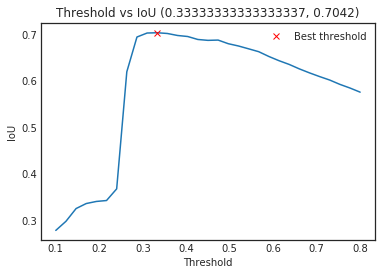

In [118]:
# first train
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

## predict_test → add dimが必要

In [26]:
import warnings
warnings.filterwarnings('ignore')
x_test = np.array([upsample(np.array(load_img("../input/images/test/images/{}.png".format(idx), grayscale=True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, 128, 128, 1)

In [27]:
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [62]:
# TTA only lr flip
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    print('pred_1 start...')
    preds_test = model.predict([x_test]).reshape(-1, img_size_target, img_size_target)
        
    print('pred_ref start...')
    preds_test_reflect = np.array([np.fliplr(x) for x in model.predict([np.array([np.fliplr(x) for x in x_test])]).reshape(-1, img_size_target, img_size_target)])
    preds_test += preds_test_reflect
    
    del preds_test_reflect
    gc.collect()
    
    return preds_test / 2

In [29]:
# average the predictions from different folds
import time
import gc
import sys

t1 = time.time()
preds_test = np.zeros(np.squeeze(x_test).shape)
model = UResNet34(input_shape=(128,128,3))

for cv_index in tqdm_notebook(range(cv_total)):
    gc.collect()
    basic_name = 'Unet_resnet_v%s_cv%s' % (version,cv_index + 1)
    model.load_weights(basic_name + '.model')
    gc.collect()

    preds_test += predict_result(model,x_test_3dim,img_size_target) / cv_total

#preds_test_all = preds_test / cv_total
t2 = time.time()
print("Usedtime = %s s" % round((t2 - t1),1))

[106, 74, 37, 5]
n_upsample_blocks:  5
Tensor("stage3_unit4_relu2/Relu:0", shape=(?, 8, 8, 256), dtype=float32)
Tensor("stage3_unit1_relu1/Relu:0", shape=(?, 16, 16, 128), dtype=float32)
Tensor("stage2_unit1_relu1/Relu:0", shape=(?, 32, 32, 64), dtype=float32)
Tensor("relu0/Relu:0", shape=(?, 64, 64, 64), dtype=float32)


pred_1 start...
pred_ref start...
pred_updown start...
pred_ref_updown start...
ave result...
(18000, 128, 128)
pred_1 start...
pred_ref start...
pred_updown start...
pred_ref_updown start...
ave result...
(18000, 128, 128)
pred_1 start...
pred_ref start...
pred_updown start...
pred_ref_updown start...
ave result...
(18000, 128, 128)
pred_1 start...
pred_ref start...
pred_updown start...
pred_ref_updown start...
ave result...
(18000, 128, 128)
pred_1 start...
pred_ref start...
pred_updown start...
pred_ref_updown start...
ave result...
(18000, 128, 128)

Usedtime = 1312.7 s


In [30]:
t1 = time.time()
#threshold_best  = 0.5 # some value in range 0.4- 0.5 may be better 
pred_dict = {idx: rle_encode(np.round(preds_test[i]) > threshold_best) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

In [ ]:
submission_file = 'Unet_resnet_5fold_20181007_adam_v1.csv'
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv(submission_file)

In [31]:
submission_file

'Unet_resnet_v1.csv'